# Sztuczny obrazek na postawie cech fraktalnych, zrobione za pomocą metody box-counting

In [1]:
import numpy as np
from matplotlib import image
from matplotlib import pyplot
from scipy.ndimage import measurements

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-x8vtro4m because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Ładujemy i wyświetlamy obrazek

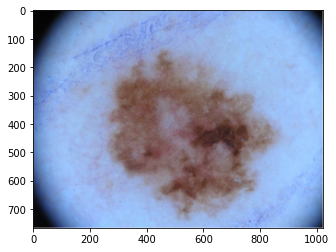

In [2]:
image = image.imread('../../small-data/MEL/ISIC_0000002.jpg')
pyplot.imshow(image)
pyplot.show()

Dzielimy obrazek na kawałki o rozmiarze $L \times L$

In [3]:
def split(image, box_size):
    target_dimention = (max(len(image), len(image[0])) // box_size + 1) * box_size
    padded_image = np.pad(image, pad_width=(
        (0, target_dimention - len(image) + 1), 
        (0, target_dimention - len(image[0]) + 1), 
        (0, 0)
    ))
    
    boxes = []
    for i in range(0, target_dimention, box_size):
        for j in range(0, target_dimention, box_size):
            box = padded_image[i:i+box_size, j:j+box_size, :]
            boxes.append(box)
            
    return boxes 

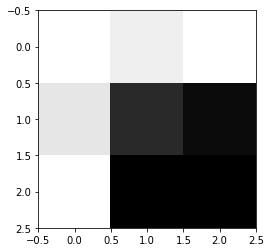

In [4]:
boxes = split(image, box_size=3)
pyplot.imshow(boxes[0])
pyplot.show()

Tworzymy binarne macierze dla każdego kawałku, według warunku <br/>
$
\left\{\begin{matrix}
1, \text{if } \Delta \leqslant L & \\ 
0, \text{if } \Delta > L & 
\end{matrix}\right.
$, <br/>

gdzie $\Delta$ - to kolorowa odległość między pikselem ($f_i$) i centralnym pikselem ($f_c$)

#### Funkcja, która oblicza odległość kolorową metodą Chessboard ($\Delta_h$)

In [5]:
def chessboard_distance(pixel_1, pixel_2):
    return max(abs(pixel_1.astype('float64') - pixel_2.astype('float64')))

In [6]:
delta_h = chessboard_distance(boxes[0][0, 0, :], boxes[0][1, 1, :])
delta_h

214.0

#### Funkcja, która oblicza odległość kolorową metodą Euklidesa ( $\Delta_e$ )

In [7]:
def euclidean_distance(pixel_1, pixel_2):
    return sum([(p1 - p2) ** 2 for p1, p2 in zip(pixel_1, pixel_2)]) ** 0.5

In [8]:
delta_e = euclidean_distance(boxes[0][0, 0, :], boxes[0][1, 1, :])
delta_e

370.6588728197397

#### Funkcja, która oblicza odległość kolorową metodą Manhattan (  $\Delta_m$  )

In [9]:
def manhattan_distance(pixel_1, pixel_2):
    return sum([abs(p1 - p2) for p1, p2 in zip(pixel_1, pixel_2)])

In [10]:
delta_m = manhattan_distance(boxes[0][0, 0, :], boxes[0][1, 1, :])
delta_m

642

Tworzymy binarne macierze na podstawie kawałków obrazka i funkcji kolorowej odłegłości

In [11]:
def binary_matrices(boxes, distance_function):
    def make_binary_matrix(box):
        box_size = len(box)
        box = box.astype(float)
        if box_size % 2 == 0:
            raise Exception('a box should have one centre')

        center = box_size // 2 + 1
        
        return (
            np.reshape([
                distance_function(pixel, box[center, center, :]) for row in box for pixel in row
            ], newshape=(box_size, box_size)) <= box_size
        ).astype(int)
    
    return [make_binary_matrix(box) for box in boxes]

In [12]:
binary_matrices_h = binary_matrices(boxes, chessboard_distance)

In [13]:
binary_matrices_e = binary_matrices(boxes, euclidean_distance)

In [14]:
binary_matrices_m = binary_matrices(boxes, manhattan_distance)

Tworzymy macierz prawdopodobieńst, że $m$ pikseli są odznaczone jako $1$

In [15]:
def make_probability(boxes):
    ones_number = np.array([box.sum() for box in boxes])
    box_size = len(boxes[0])
    
    result = {}
    for i in range(1, box_size ** 2 + 1):
        result[i] = (ones_number == i).astype(int).sum() /  len(boxes)
        
    return result

In [16]:
probability_table_h = make_probability(binary_matrices_h)
probability_table_h

{1: 0.020123665947145278,
 2: 0.04631883110740362,
 3: 0.10015393744463842,
 4: 0.059382014258563307,
 5: 0.060921388704947496,
 6: 0.09543261581857741,
 7: 0.06358734445008213,
 8: 0.0630283537293281,
 9: 0.4910518485393143}

In [17]:
sum(probability_table_h.values())

1.0

In [18]:
probability_table_e = make_probability(binary_matrices_e)
probability_table_e

{1: 0.08377980925516637,
 2: 0.11254633173089326,
 3: 0.14833893757363628,
 4: 0.07970347692228309,
 5: 0.06534171532752556,
 6: 0.08224903466602454,
 7: 0.046060835390132525,
 8: 0.03812316715542522,
 9: 0.34385669197891316}

In [19]:
sum(probability_table_e.values())

1.0

In [20]:
probability_table_m = make_probability(binary_matrices_m)
probability_table_m

{1: 0.10852159854146422,
 2: 0.1292988536390296,
 3: 0.15554561794274216,
 4: 0.07672792631642315,
 5: 0.05897782096817193,
 6: 0.0764871303136368,
 7: 0.038355363300969204,
 8: 0.03042629492350427,
 9: 0.3256593940540587}

In [21]:
sum(probability_table_m.values())

1.0

Obliczamy wymiar fraktalny (ang. fractal dimension)

In [22]:
def fractal_dimension(probability_table):
    return sum([P / m for m, P in probability_table.items()])

In [23]:
fractal_dimension(probability_table_h)

0.19112671166166578

In [24]:
fractal_dimension(probability_table_e)

0.2857534867302155

In [25]:
fractal_dimension(probability_table_m)

0.3142119670972191

Obliczamy lakunarność (ang. lacunarity)

In [26]:
def lacunarity(p_matrix):
    mu = sum([m * P for m, P in p_matrix.items()])
    mu_sqr = sum([m ** 2 * P for m, P in p_matrix.items()])
    
    return (mu_sqr - mu ** 2) / mu ** 2

In [27]:
lacunarity(probability_table_h)

0.13402672985818473

In [28]:
lacunarity(probability_table_e)

0.2778277864728894

In [29]:
lacunarity(probability_table_m)

0.3229365493062333

Obliczamy średnia ilość klasterów

Patrz: [Working with percolation clusters in Python](https://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/)

In [30]:
def average_cluster_number(boxes):
    cluster_number_total = 0
    for box in boxes:
        _, cluster_number_in_box =  measurements.label(box)
        cluster_number_total += cluster_number_in_box
        
    return cluster_number_total / len(boxes)

In [31]:
average_cluster_number(binary_matrices_h)

1.0333588462431524

In [32]:
average_cluster_number(binary_matrices_e)

1.0870305552927821

In [33]:
average_cluster_number(binary_matrices_m)

1.08386580782759

Obliczamy średnia powierzchnia największego klastera

In [34]:
def average_cluster_max_area(boxes):
    cluster_max_area_total = 0
    for box in boxes:
        clusters, _ =  measurements.label(box)
        cluster_areas = measurements.sum(box, clusters, index=np.arange(clusters.max() + 1))
        cluster_max_area_total += max(cluster_areas)
        
    return cluster_max_area_total / len(boxes)

In [35]:
average_cluster_max_area(binary_matrices_h)

6.856124388335154

In [36]:
average_cluster_max_area(binary_matrices_e)

5.516120432400822

In [37]:
average_cluster_max_area(binary_matrices_m)

5.243857551964638

Obliczamy średnia perkolacja (ang. average percolation)

In [38]:
def average_percolation(boxes):
    threshold = 0.59275
    return sum((np.array([box.sum() / len(box) ** 2 for box in boxes]) >= threshold).astype(int)) / len(boxes)

In [39]:
average_percolation(binary_matrices_h)

0.7131001625373019

In [40]:
average_percolation(binary_matrices_e)

0.5102897291904954

In [41]:
average_percolation(binary_matrices_m)

0.47092818259216895

Zbieramy wszystkie funkcje razem, żeby stworzyć sztuczny obrazek na podstawie cech fraktalnych

In [42]:
def extract_fractal_image(image, scale_range, distance_functions):
    result = []
    for df in distance_functions:
        fractal_dimensions = []
        lacunarities = []
        average_cluster_numbers = []
        average_cluster_max_areas = []
        average_percolations = []
        for scale in range(scale_range[0], scale_range[1] + 1, 2):
            boxes = split(image, box_size=scale)
            binary_matrices_h = binary_matrices(boxes, df)
            probability_table_h = make_probability(binary_matrices_h)

            fractal_dimensions.append(fractal_dimension(probability_table_h))
            lacunarities.append(lacunarity(probability_table_h))
            average_cluster_numbers.append(average_cluster_number(binary_matrices_h))
            average_cluster_max_areas.append(average_cluster_max_area(binary_matrices_h))
            average_percolations.append(average_percolation(binary_matrices_h))

        result.append([*average_cluster_numbers, 
                       *average_percolations, 
                       *average_cluster_max_areas, 
                       *lacunarities, 
                       *fractal_dimensions])
        
    return np.reshape(result, newshape=(10, 10, 3))

In [43]:
fractal_image = extract_fractal_image(image, 
                                      scale_range=(3, 41), 
                                      distance_functions=[chessboard_distance,
                                                          euclidean_distance,
                                                          manhattan_distance])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


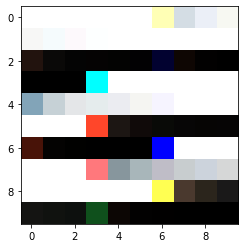

In [44]:
pyplot.imshow(fractal_image)
pyplot.show()